In [ ]:
import sqlalchemy as sq
import pandas as pd
import matplotlib.pyplot as plt
from haversine import haversine, Unit
from sklearn.metrics import pairwise_distances
import numpy as np

### Requirements
* From Home to Home
* Show which factories were visited
* How many beer types collected
* What distance was travelled
* Runtime

* Simple GUI

In [14]:
engine = sq.create_engine('sqlite:///db/beer.db')

tbl = 'geocodes'

query = f"""SELECT * FROM {tbl}"""
df = pd.read_sql_query(query, engine)
print(df.shape)

df

(1304, 6)


,index,id,brewery_id,latitude,longitude,accuracy
0,0,1,1,30.223400,-97.769699,ROOFTOP
1,1,2,2,37.782501,-122.392998,ROOFTOP
2,2,3,3,50.766800,4.308100,RANGE_INTERPOLATED
3,3,4,4,59.745098,10.213500,APPROXIMATE
4,4,5,5,50.260601,4.912200,APPROXIMATE
...,...,...,...,...,...,...
1299,1299,1311,1390,45.786098,-108.498001,ROOFTOP
1300,1300,1312,1389,53.957100,-1.090500,RANGE_INTERPOLATED
1301,1301,1313,1385,51.461102,-0.196600,RANGE_INTERPOLATED
1302,1302,1314,1388,40.700001,-76.174698,ROOFTOP


### Join tables
Required fields
* **beers** table  `id`, `name` (indicates beer categories);
* **breweries** table `id`, `name` (brewing company name for pop up map)
* **geocodes** table `latitude`, `longitude`;





In [16]:
query = f"""
SELECT a.brewery_id, a.name as beer_type, b.name as brewery_name, latitude, longitude
FROM beers a
JOIN breweries b
ON a.brewery_id = b.id
JOIN geocodes c
ON a.brewery_id = c.brewery_id

"""
df = pd.read_sql_query(query, engine)
print(df.shape)

(5754, 5)


In [18]:
coord = ['latitude','longitude']
df[df.duplicated(subset=coord, keep=False)].sort_values(by=coord)

,brewery_id,beer_type,brewery_name,latitude,longitude
1176,498,Old 95,Emerson Brewing,-45.872002,170.518005
1177,498,Taieri George,Emerson Brewing,-45.872002,170.518005
5031,881,Monteith's Summer Ale,Monteith's Brewing Co.,-42.450500,171.207001
5032,881,Monteith's Celtic Beer,Monteith's Brewing Co.,-42.450500,171.207001
134,397,Dark Ale,Coopers Brewery,-34.872700,138.572998
...,...,...,...,...,...
5506,885,Dark Knight,Moose's Tooth Pub and Pizzeria,61.190201,-149.869003
3513,1040,IPA Pale Ale,Railway Brewing,61.218102,-149.899994
3514,1040,Ironhorse Not Brown,Railway Brewing,61.218102,-149.899994
3515,1144,Anchorage Ale,Silver Gulch Brewing Company,64.958298,-147.621994


In [20]:
# Find a symbol which is never present in beer names
# so that it could be used to concatenate strings
# and later on retrieve number of unique beers
[x for x in df['beer_type'] if "|" in x]

[]

In [21]:
# Check how many unique locations
df.drop_duplicates(subset=['brewery_name','brewery_id','latitude','longitude'], keep='first').shape

(1231, 5)

In [22]:
df_agg = df.copy()
group = ['brewery_id','brewery_name','latitude','longitude']
df_agg = df_agg.groupby(group)['beer_type'].agg(lambda x: '|'.join(x)).reset_index()
df_agg.head()

,brewery_id,brewery_name,latitude,longitude,beer_type
0,1,(512) Brewing Company,30.223400,-97.769699,(512) Wit|(512) Pale|(512) IPA|(512) Pecan Por...
1,2,21st Amendment Brewery Cafe,37.782501,-122.392998,South Park Blonde|Bitter American|Watermelon W...
2,3,3 Fonteinen Brouwerij Ambachtelijke Geuzestekerij,50.766800,4.308100,Oude Geuze|Drie Fonteinen Kriek
3,4,Aass Brewery,59.745098,10.213500,Classic Special Brew|JuleÃ¸l|Bock Beer|Genuine...
4,5,Abbaye de Leffe,50.260601,4.912200,Brune (Brown)|Leffe Blonde


In [53]:
# Settings
MAX_DISTANCE = 2000 # maximum travel distance
INPUT_LAT = 51.355468 # home coordinates
INPUT_LON = 11.100790 # home coordinates
starting_point = [INPUT_LAT, INPUT_LON]
coord = ['latitude','longitude']

home = pd.DataFrame(
    {
    'brewery_id':0,
    'brewery_name':'HOME',
    'latitude':INPUT_LAT,
    'longitude':INPUT_LON,
    'beer_type':''
    }, index=[0]
)

In [54]:
df_loc = pd.concat([home, df_agg, home]).reset_index(drop=True)#.values

# Discard places which are too far from starting point
# Filter distance matrix and sort by distance
df_loc['distance'] = df_loc.apply(lambda x: haversine(starting_point, [x['latitude'], x['longitude']]), axis=1)
df_loc = df_loc.sort_values(by='distance')
df_loc = df_loc[df_loc['distance'] < MAX_DISTANCE*0.4]

points_coordinate = df_loc[coord].copy()

distance_matrix = pairwise_distances(
    X=points_coordinate,
    metric=haversine
)
# overwrite with dummy distances
dummy = points_coordinate.shape[0]-1
distance_matrix[:,dummy] = 0
distance_matrix[dummy,:] = 0

print(points_coordinate.shape, distance_matrix.shape)
num_points = points_coordinate.shape[0]
num_points = num_points-1 if num_points % 2 == 1 else points_coordinate.shape[0]

(107, 2) (107, 107)


### Genetic Algorithm for TSP(Travelling Salesman Problem)

In [55]:
def cal_total_distance(routine):
    '''The objective function. input routine, return total distance.
    cal_total_distance(np.arange(num_points))
    '''
    num_points, = routine.shape
    return sum([distance_matrix[routine[i % num_points], routine[(i + 1) % num_points]] for i in range(num_points)])

Number of breweries: 15
[ 5  6  7  9 11 12  8 14 13 10  0  1  4  3  2] [48.16301687]
0 days 00:00:01.616670


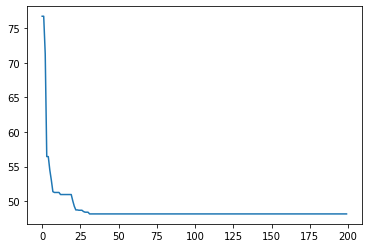

Number of breweries: 20
[ 4  3 19  2  5  6  7  9 11 12  8 15 14 13 10 16 17 18  0  1] [116.87478614]
0 days 00:00:03.692106


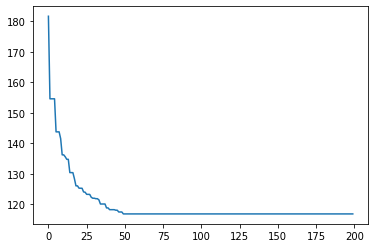

Number of breweries: 25
[16 17 18  0  1  4  3 21 22 24 20 23 19  2  5  6  7  9 11 12  8 15 14 13
 10] [123.13899323]
0 days 00:00:05.952054


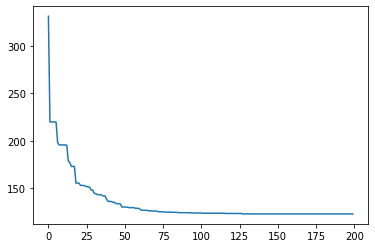

Number of breweries: 30
[ 3  4 28 27 29 25 24 21 22 20 23 19  2 11 12  9  7  5  6  8 14 15 13 10
 16 17 26 18  1  0] [181.71510086]
0 days 00:00:08.510184


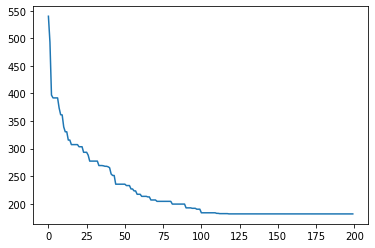

Number of breweries: 35
[23 20 21 22 24 25 29 27 28  4  3  0  1 10 18 33 34 26 17 16 14 15 13  8
 12 11  9  7  6  5  2 31 32 30 19] [256.79118209]
0 days 00:00:11.295733


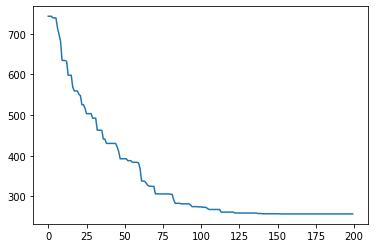

Number of breweries: 40
[36 38 27 29 39 37 35 31 32 30 23 24 25 21 22 20 19  2  5  6  7  9 11 12
  8 13 14 15 16 17 26 33 34 18 10  1  0  3  4 28] [428.56179641]
0 days 00:00:14.308706


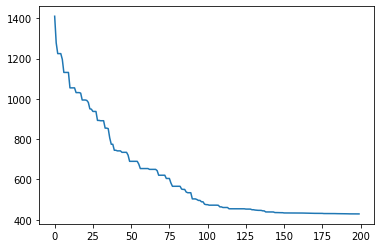

Number of breweries: 45
[27 28 36 38 40 42 34 33 26 18 17 16 10 13 15 14 12  8  6  9 11  7  5  2
  0  1  4  3 30 32 31 41 44 43 37 39 35 19 20 23 21 22 24 25 29] [572.52792736]
0 days 00:00:17.748505


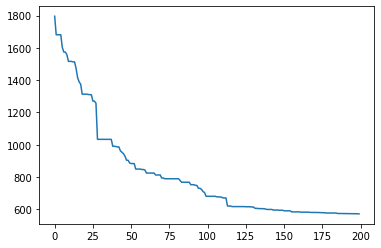

Number of breweries: 50
[17 18 26 33 34 47 49 36 42 48 40 38 28 27 29 39 37 43 46 45 44 41 31 32
 30 35 24 25 21 22 23 20 19  3  4  0  1  2  5  8 12 13 15 10  7 11  9  6
 14 16] [688.37211052]
0 days 00:00:21.470547


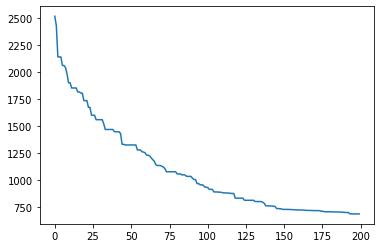

Number of breweries: 55
[29 39 37 46 44 45 43 53 41 31 32 30 35 20 24 25 23 22 19 21  1  2  7 11
  9 15 13 10 16 17 14  8  6 12  5  0  4  3 27 18 26 33 34 49 50 47 52 54
 51 48 42 38 40 36 28] [1058.90341365]
0 days 00:00:25.414994


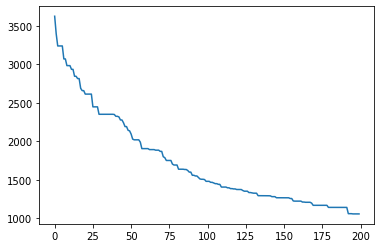

Number of breweries: 60
[48 42 38  3  1 15 14  7 12  8  6  5  9 13 16 17 10 26  0 20 29 37 43 46
 45 44 53 56 39 35 41 30 32 31 23 24 19 25 22 21  4  2 11 28 27 18 33 34
 47 49 50 52 54 59 57 58 55 51 40 36] [2167.88682448]
0 days 00:00:29.620739


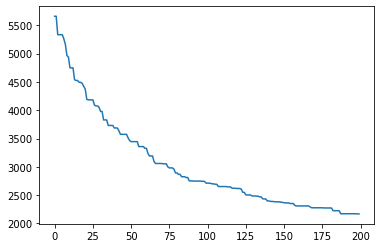

Number of breweries: 55
[ 5  6  7  9 11 12  8 15 14 13 10 16 17 18 26 33 34 47 49 50 52 54 51 48
 42 40 38 36 39 37 35 43 46 45 44 53 41 32 31 30 19 23 20 22 21 24 25 29
 27 28  4  3  1  0  2] [963.98923417]
Map completed, saving as visited_breweries.html
0 days 00:00:38.988646


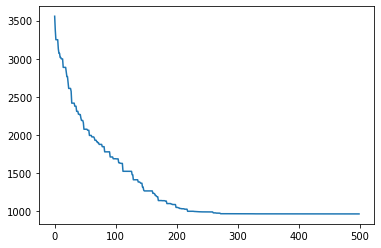

In [57]:
from sko.GA import GA_TSP
from utils.functions import generate_map

np.random.seed(2021)

start = pd.Timestamp.now()

dim = 10 # initial number of breweries from which to start
incr = 5 # increment by this number of breweries
best_distance = 0

# Find out optimal number dims (breweries)

while best_distance < MAX_DISTANCE:

    dim += incr

    print(f"Number of breweries: {dim}")
    ga_tsp = GA_TSP(func=cal_total_distance, n_dim=dim, size_pop=num_points, max_iter=200, prob_mut=0.7)
    best_points, best_distance = ga_tsp.run()
    print(best_points, best_distance)

    # %% plot
    best_points_ = np.concatenate([best_points, [best_points[0]]])
    best_points_coordinate = points_coordinate.values[best_points_, :]

    print(pd.Timestamp.now()-start)

    plt.plot(ga_tsp.generation_best_Y)
    plt.show()

# Retrain final result with more iterations
dim -= 5

print(f"Number of breweries: {dim}")
ga_tsp = GA_TSP(func=cal_total_distance, n_dim=dim, size_pop=num_points, max_iter=500, prob_mut=0.7)
best_points, best_distance = ga_tsp.run()
print(best_points, best_distance)

# reorder the whole route so that start and end is at HOME (index 0)
ls = list(best_points)
best_points = ls[ls.index(0):] + ls[:ls.index(0)]
best_points_ = np.concatenate([best_points, [best_points[0]]])
best_points_coordinate = points_coordinate.values[best_points_, :]

generate_map(
    dataframe=df_loc.iloc[best_points,:],
    lat_col='latitude',
    long_col='longitude',
    home=starting_point,
    filename='visited_breweries'
    )
print(pd.Timestamp.now()-start)

plt.plot(ga_tsp.generation_best_Y)
plt.show()

In [60]:
generate_map(
    dataframe=df_loc.iloc[best_points,:],
    lat_col='latitude',
    long_col='longitude',
    home=starting_point,
    filename='visited_breweries'
    )

Map completed, saving as visited_breweries.html


In [32]:
dist_from_home = 0
l = len(best_points)
for k in range(l-1):

    dist_from_home += distance_matrix[best_points[k],best_points[k+1]]

dist_from_home

1905.5877115276837

In [33]:
ls = df_loc.iloc[best_points,:]['beer_type'].tolist()
collected_beers = '|'.join(map(str, ls))
coll_uniq_beers = collected_beers.split('|')
coll_uniq_beers = [x for x in np.unique(coll_uniq_beers) if x != '']
len(coll_uniq_beers)

92